Test Accuracy: 0.844
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1008
           1       0.86      0.82      0.84       992

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



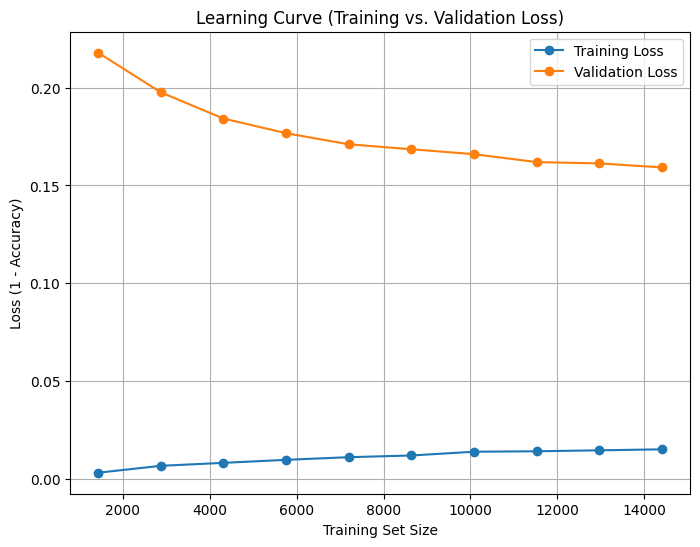

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import learning_curve

# =======================
# Data Preparation
# =======================

data_df = pd.read_csv('clean_data.csv')
data_df = data_df.sample(n=20000, random_state=1).reset_index(drop=True)
data_df['Rating'] = pd.to_numeric(data_df['Rating'], errors='coerce')
data_df = data_df.dropna(subset=['Rating'])
data_df['Rating'] = data_df['Rating'].astype(int)

# Slit between test and train.
train_df = data_df.iloc[:18000].reset_index(drop=True)
test_df = data_df.iloc[18000:].reset_index(drop=True)
for col in ['Title', 'Review']:
    train_df[col] = train_df[col].fillna('').astype(str)
    test_df[col] = test_df[col].fillna('').astype(str)
    
X_train = train_df[['Title', 'Review']]
y_train = train_df['Rating']
X_test = test_df[['Title', 'Review']]
y_test = test_df['Rating']

# =======================
# Pipeline Construction
# =======================

get_title = FunctionTransformer(lambda x: x['Title'], validate=False)
get_review = FunctionTransformer(lambda x: x['Review'], validate=False)
title_pipeline = Pipeline([
    ('selector', get_title),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])
review_pipeline = Pipeline([
    ('selector', get_review),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])
combined_features = FeatureUnion(
    transformer_list=[
        ('title', title_pipeline),
        ('review', review_pipeline)
    ],
    transformer_weights={'title': 0.2, 'review': 0.8}
)
pipeline = Pipeline([
    ('features', combined_features),
    ('svc', SVC())  
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# =======================
# Generate Learning Curve
# =======================

train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X_train, y_train, 
    n_jobs=-1,          
    train_sizes=np.linspace(0.1, 1.0, 10), #  Creates 10 seperate plotting values.
    scoring='accuracy'
)


train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
train_loss = 1 - train_scores_mean
val_loss = 1 - val_scores_mean


# Plot the learning curve.
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_loss, 'o-', label="Training Loss")
plt.plot(train_sizes, val_loss, 'o-', label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Loss (1 - Accuracy)")
plt.title("Learning Curve (Training vs. Validation Loss)")
plt.legend()
plt.grid(True)
plt.show()
